# Bibliotek

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

# Funksjoner

In [109]:
def calculate_chlorophyll_a(reflectance_data):
    a = 25.28
    b = 14.85
    c = -15.18
    
    # Extract all columns that start with 'reflectance_'
    reflectance_columns = [col for col in reflectance_data.columns if col.startswith('reflectance')]
    
    # Initialize a dictionary to store the results
    chlorophyll_a_results = {}
    
    for col in reflectance_columns:
        # Extract reflectance values at the specific wavelengths
        Rrs_709 = reflectance_data.loc[reflectance_data['lambda'] == 709, col].values
        Rrs_665 = reflectance_data.loc[reflectance_data['lambda'] == 665, col].values

        # Ensure we have the reflectance values
        if Rrs_709.size > 0 and Rrs_665.size > 0:
            Rrs_709_value = Rrs_709[0]
            Rrs_665_value = Rrs_665[0]
            
            # Calculate Chl-a using the given empirical formula
            Chl_a = a * (Rrs_709_value / Rrs_665_value) ** 2 + b * (Rrs_709_value / Rrs_665_value) + c
            chlorophyll_a_results[col] = Chl_a
        else:
            print(f"Reflectance values for 709 nm or 665 nm are not available in column {col}.")
            chlorophyll_a_results[col] = None
    
    return chlorophyll_a_results

def moving_average(data, window_size=30):
    return data.rolling(window=window_size, center=True).mean()

def parse_output(filename):
    """
    Parse the SC1.OUT, SC3.OUT and SC4.OUT file for three different heights (0m, 120m, and TOA) with outputs lambda, edir, edn, eup, and uu.

    Parameters:
    - filename: Path to the SC1.OUT file.

    Returns:
    - df_0m: DataFrame containing the parsed data for 0m.
    - df_120m: DataFrame containing the parsed data for 120m.
    - df_TOA: DataFrame containing the parsed data for TOA.
    """

    # Define column names
    columns = ['lambda', 'edir', 'edn', 'eup', 'uu']

    # Read the file
    df = pd.read_table(filename, sep=r'\s+', header=None, names=columns)
    
# Split the data into three different heights
    df_0m = df.iloc[::3].copy().reset_index(drop=True)
    df_120m = df.iloc[1::3].copy().reset_index(drop=True)
    df_TOA = df.iloc[2::3].copy().reset_index(drop=True)

    # Calculate reflectance
    df_0m['reflectance'] = df_0m['uu'] / (df_0m['edir'] + df_0m['edn'])
    df_120m['reflectance'] = df_120m['uu'] / (df_120m['edir'] + df_120m['edn'])
    df_TOA['reflectance'] = df_TOA['uu'] / (df_TOA['edir'] + df_TOA['edn'])

    return df_0m, df_120m, df_TOA

def parse_output_multiple_uu(filename):
    """
    Parse the SC2.OUT file for three different heights (0m, 120m, and TOA) with outputs lambda, edir, edn, eup, and multiple uu values.

    Parameters:
    - filename: Path to the SC1.OUT file.

    Returns:
    - df_0m: DataFrame containing the parsed data for 0m.
    - df_120m: DataFrame containing the parsed data for 120m.
    - df_TOA: DataFrame containing the parsed data for TOA.
    """
     # Read the file into a pandas DataFrame
    df = pd.read_table(filename, sep=r'\s+', header=None)

    # Define column names dynamically based on the number of uu columns
    sample_line = df.iloc[0].tolist()
    num_uu = len(sample_line) - 4  # Subtracting 4 for lambda, edir, edn, and eup
    columns = ['lambda', 'edir', 'edn', 'eup'] + [f'uu{i+1}' for i in range(num_uu)]
    df.columns = columns

    # Split the data into three different heights
    df_0m = df.iloc[::3].copy().reset_index(drop=True)
    df_120m = df.iloc[1::3].copy().reset_index(drop=True)
    df_TOA = df.iloc[2::3].copy().reset_index(drop=True)

    # Calculate reflectance for each uu column
    for i in range(num_uu):
        uu_col = f'uu{i+1}'
        df_0m[f'reflectance_{uu_col}'] = df_0m[uu_col] / (df_0m['edir'] + df_0m['edn'])
        df_120m[f'reflectance_{uu_col}'] = df_120m[uu_col] / (df_120m['edir'] + df_120m['edn'])
        df_TOA[f'reflectance_{uu_col}'] = df_TOA[uu_col] / (df_TOA['edir'] + df_TOA['edn'])

    return df_0m, df_120m, df_TOA


def BlackBody(w,T) :
    h = 6.62606957e-34 # joule·s 
    c = 2.99792458e8 # Speed of light in m/s 
    k = 1.38e-23 # Boltzmann constant in m^2 kg / s^2 / K  
    intensity = (2*h*c**2/w**5)*(1/(np.exp((h*c)/(w*k*T))- 1))*10**3 # in mW/m^2/nm/sr
    return intensity

def BlackBodySun(w,T,R_sun_earth=149600000):
    R_sun=696340 
    return BlackBody(w,T)*(R_sun/R_sun_earth)**2*1.0e-9*np.pi

# Scenario 1 - Clean Sky

  Altitude  Chl-a ingen brdf  Chl-a med brdf
0      0 m         24.949980       49.598789
1    120 m         24.848076       22.016449
2      TOA         23.252597       25.775853


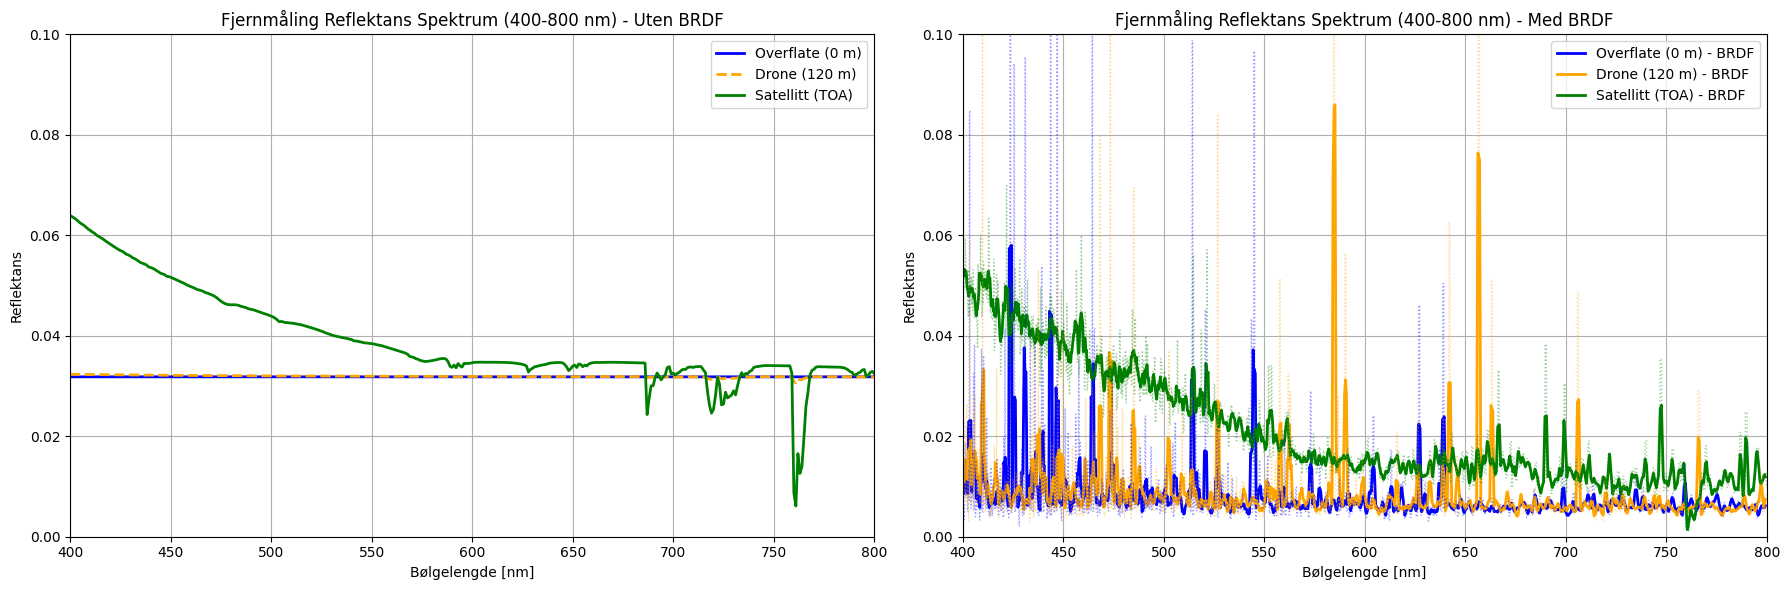

In [110]:
# load data
SC1_0m, SC1_120m, SC1_TOA = parse_output('Data/SC1.OUT')

brdf_cols = ['lambda', 'edir', 'edn', 'eup', 'gh', 'actinic', 'uu']

SC1_0m_brdf = np.loadtxt('Data/SC1_0m_brdf.OUT')
SC1_0m_brdf = pd.DataFrame(SC1_0m_brdf, columns=brdf_cols)
SC1_0m_brdf['reflectance'] = SC1_0m_brdf['uu'] / (SC1_0m_brdf['edir']+SC1_0m_brdf['edn'])

SC1_120m_brdf = np.loadtxt('Data/SC1_120m_brdf.OUT')
SC1_120m_brdf = pd.DataFrame(SC1_120m_brdf, columns=brdf_cols)
SC1_120m_brdf['reflectance'] = SC1_120m_brdf['uu'] / (SC1_120m_brdf['edir']+SC1_120m_brdf['edn'])

SC1_TOA_brdf = np.loadtxt('Data/SC1_TOA_brdf.OUT')
SC1_TOA_brdf = pd.DataFrame(SC1_TOA_brdf, columns=brdf_cols)
SC1_TOA_brdf['reflectance'] = SC1_TOA_brdf['uu'] / (SC1_TOA_brdf['edir']+SC1_TOA_brdf['edn'])

SC1_0m_brdf['reflectance_smooth'] = moving_average(SC1_0m_brdf['reflectance'])
SC1_120m_brdf['reflectance_smooth'] = moving_average(SC1_120m_brdf['reflectance'])
SC1_TOA_brdf['reflectance_smooth'] = moving_average(SC1_TOA_brdf['reflectance'])

# Calculate Chl-a for each dataset
chl_a_0m = calculate_chlorophyll_a(SC1_0m)
chl_a_0m_brdf = calculate_chlorophyll_a(SC1_0m_brdf)
chl_a_120m = calculate_chlorophyll_a(SC1_120m)
chl_a_120m_brdf = calculate_chlorophyll_a(SC1_120m_brdf)
chl_a_TOA = calculate_chlorophyll_a(SC1_TOA)
chl_a_TOA_brdf = calculate_chlorophyll_a(SC1_TOA_brdf)

chl_df = pd.DataFrame({
    'Altitude': ['0 m', '120 m', 'TOA'],
    'Chl-a ingen brdf': [chl_a_0m.get('reflectance'), chl_a_120m.get('reflectance'), chl_a_TOA.get('reflectance')],
    'Chl-a med brdf': [chl_a_0m_brdf.get('reflectance'), chl_a_120m_brdf.get('reflectance'), chl_a_TOA_brdf.get('reflectance')]
})

print(chl_df)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot reflectance spectra without Ocean BRDF in the first subplot
ax[0].plot(SC1_0m['lambda'], SC1_0m['reflectance'], label='Overflate (0 m)', linewidth=2, color='blue')
ax[0].plot(SC1_120m['lambda'], SC1_120m['reflectance'], label='Drone (120 m)', linewidth=2, color='orange', linestyle='--')
ax[0].plot(SC1_TOA['lambda'], SC1_TOA['reflectance'], label='Satellitt (TOA)', linewidth=2, color='green')
ax[0].set_xlabel('Bølgelengde [nm]')
ax[0].set_ylabel('Reflektans')
ax[0].set_title('Fjernmåling Reflektans Spektrum (400-800 nm) - Uten BRDF')
ax[0].legend()
ax[0].set_xlim(400, 800)
ax[0].set_ylim(0, 0.1)
ax[0].grid(True)

# Plot reflectance spectra with Ocean BRDF in the second subplot 
ax[1].plot(SC1_0m_brdf['lambda'], SC1_0m_brdf['reflectance_smooth'], label='Overflate (0 m) - BRDF', linewidth=2, color='blue')
ax[1].plot(SC1_120m_brdf['lambda'], SC1_120m_brdf['reflectance_smooth'], label='Drone (120 m) - BRDF', linewidth=2, color='orange')
ax[1].plot(SC1_TOA_brdf['lambda'], SC1_TOA_brdf['reflectance_smooth'], label='Satellitt (TOA) - BRDF', linewidth=2, color='green')

ax[1].plot(SC1_0m_brdf['lambda'], SC1_0m_brdf['reflectance'], linewidth=1, linestyle=':', alpha=0.4, color='blue')
ax[1].plot(SC1_120m_brdf['lambda'], SC1_120m_brdf['reflectance'], linewidth=1, linestyle=':', alpha=0.4, color='orange')
ax[1].plot(SC1_TOA_brdf['lambda'], SC1_TOA_brdf['reflectance'], linewidth=1, linestyle=':', alpha=0.4, color='green')

ax[1].set_xlabel('Bølgelengde [nm]')
ax[1].set_ylabel('Reflektans')
ax[1].set_title('Fjernmåling Reflektans Spektrum (400-800 nm) - Med BRDF')
ax[1].legend()
ax[1].set_xlim(400, 800)
ax[1].set_ylim(0, 0.1)
ax[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Scenario 2 - Clean Sky

  Altitude  Chl-a (0° azimuth)  Chl-a (90° azimuth)
0      0 m           24.949980             24.94998
1    120 m           24.813776             24.82962
2      TOA           22.359699             23.06370


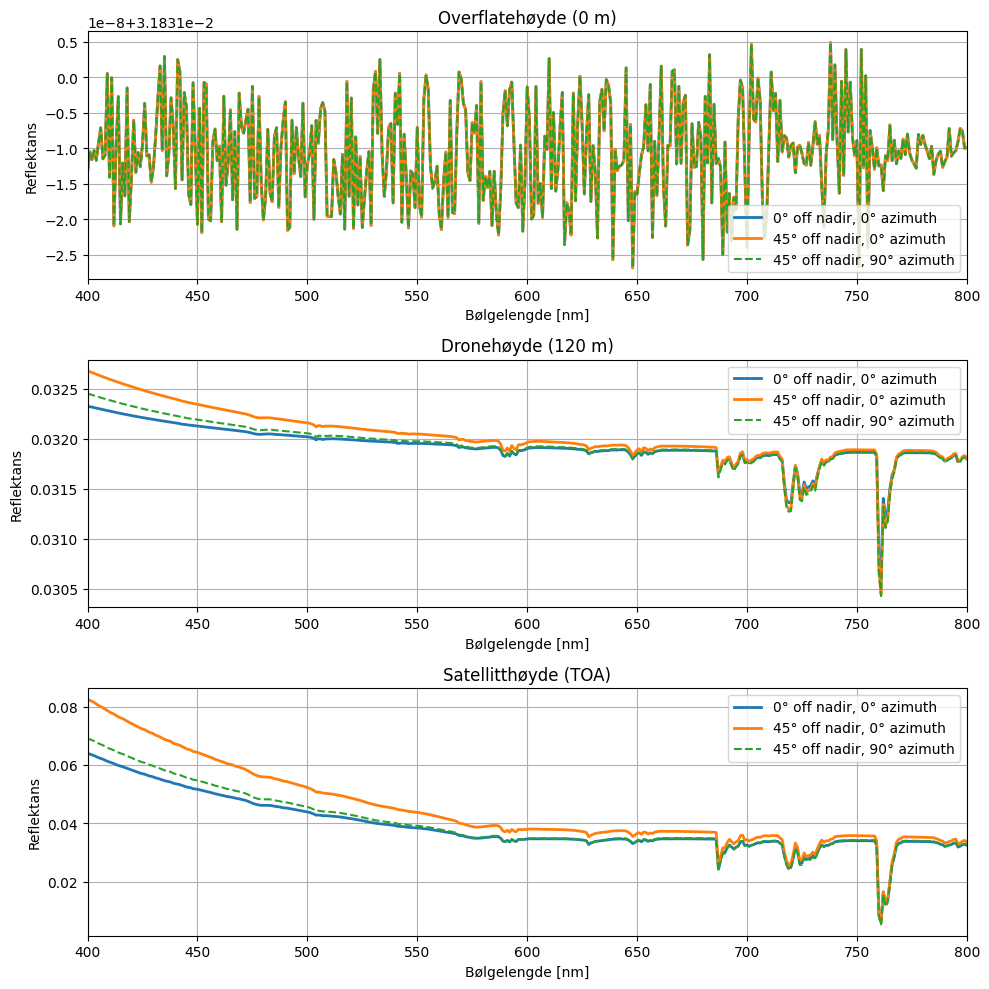

In [111]:
SC2_0m, SC2_120m, SC2_TOA = parse_output_multiple_uu('Data/SC2.OUT')

# calculate Chl-a for each dataset
chl_a_0m = calculate_chlorophyll_a(SC2_0m)
chl_a_120m = calculate_chlorophyll_a(SC2_120m)
chl_a_TOA = calculate_chlorophyll_a(SC2_TOA)

chl_a_df = pd.DataFrame({
    'Altitude': ['0 m', '120 m', 'TOA'],
    'Chl-a (0° azimuth)': [chl_a_0m.get('reflectance_uu1'), chl_a_120m.get('reflectance_uu1'), chl_a_TOA.get('reflectance_uu1')],
    'Chl-a (90° azimuth)': [chl_a_0m.get('reflectance_uu2'), chl_a_120m.get('reflectance_uu2'), chl_a_TOA.get('reflectance_uu2')]
})

print(chl_a_df)


fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].plot(SC1_0m['lambda'], SC1_0m['reflectance'], label='0° off nadir, 0° azimuth', linewidth=2)
ax[0].plot(SC2_0m['lambda'], SC2_0m['reflectance_uu1'], label='45° off nadir, 0° azimuth', linewidth=2)
ax[0].plot(SC2_0m['lambda'], SC2_0m['reflectance_uu2'], label='45° off nadir, 90° azimuth', linewidth=1.5, linestyle='--')
ax[0].set_title('Overflatehøyde (0 m)')
ax[0].set_xlabel('Bølgelengde [nm]')
ax[0].set_ylabel('Reflektans')
ax[0].legend()
ax[0].set_xlim(400, 800)
ax[0].grid(True)

ax[1].plot(SC1_120m['lambda'], SC1_120m['reflectance'], label='0° off nadir, 0° azimuth', linewidth=2)
ax[1].plot(SC2_120m['lambda'], SC2_120m['reflectance_uu1'], label='45° off nadir, 0° azimuth', linewidth=2)
ax[1].plot(SC2_120m['lambda'], SC2_120m['reflectance_uu2'], label='45° off nadir, 90° azimuth', linewidth=1.5, linestyle='--')
ax[1].set_title('Dronehøyde (120 m)')
ax[1].set_xlabel('Bølgelengde [nm]')
ax[1].set_ylabel('Reflektans')
ax[1].legend()
ax[1].set_xlim(400, 800)
ax[1].grid(True)

ax[2].plot(SC1_TOA['lambda'], SC1_TOA['reflectance'], label='0° off nadir, 0° azimuth', linewidth=2)
ax[2].plot(SC2_TOA['lambda'], SC2_TOA['reflectance_uu1'], label='45° off nadir, 0° azimuth', linewidth=2)
ax[2].plot(SC2_TOA['lambda'], SC2_TOA['reflectance_uu2'], label='45° off nadir, 90° azimuth', linewidth=1.5, linestyle='--')   
ax[2].set_title('Satellitthøyde (TOA)')
ax[2].set_xlabel('Bølgelengde [nm]')
ax[2].set_ylabel('Reflektans')
ax[2].legend()
ax[2].set_xlim(400, 800)
ax[2].grid(True)

plt.tight_layout()

plt.show()

# Scenario 3 - Oceanic Aerosols

  Altitude      Chl-a
0      0 m  24.950009
1    120 m  24.830498
2      TOA  22.928411


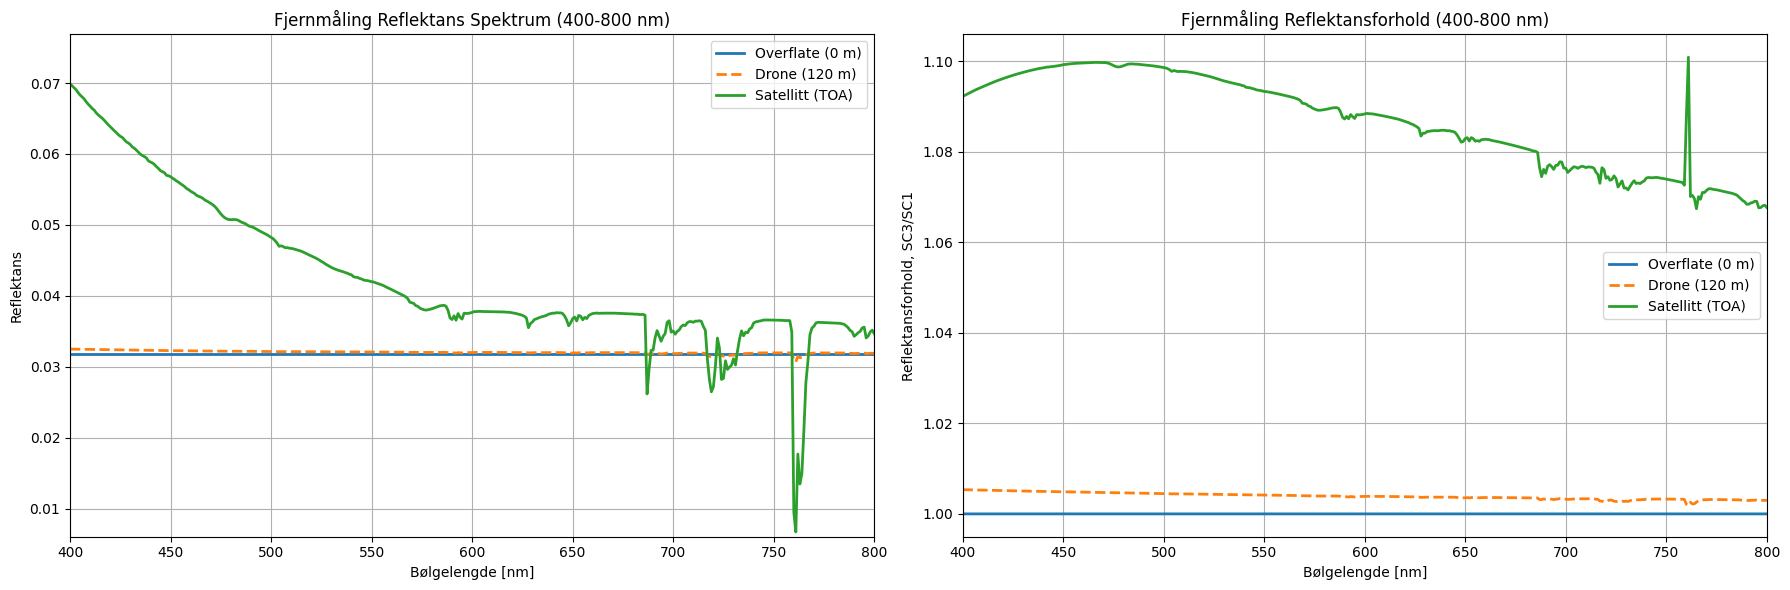

In [112]:
SC3_0m, SC3_120m, SC3_TOA = parse_output('Data/SC3.OUT')

# Calculate Chl-a for each dataset
chl_a_0m = calculate_chlorophyll_a(SC3_0m)
chl_a_120m = calculate_chlorophyll_a(SC3_120m)
chl_a_TOA = calculate_chlorophyll_a(SC3_TOA)

chl_df = pd.DataFrame({
    'Altitude': ['0 m', '120 m', 'TOA'],
    'Chl-a': [chl_a_0m.get('reflectance'), chl_a_120m.get('reflectance'), chl_a_TOA.get('reflectance')]
})

print(chl_df)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot reflectance spectra in the first subplot
ax[0].plot(SC3_0m['lambda'], SC3_0m['reflectance'], label='Overflate (0 m)', linewidth=2)
ax[0].plot(SC3_120m['lambda'], SC3_120m['reflectance'], label='Drone (120 m)', linewidth=2, linestyle='--')
ax[0].plot(SC3_TOA['lambda'], SC3_TOA['reflectance'], label='Satellitt (TOA)', linewidth=2)
ax[0].set_xlabel('Bølgelengde [nm]')
ax[0].set_ylabel('Reflektans')
ax[0].set_title('Fjernmåling Reflektans Spektrum (400-800 nm)')
ax[0].legend()
ax[0].set_xlim(400, 800)
ax[0].set_ylim(
    min(SC3_0m['reflectance'].min(), SC3_120m['reflectance'].min(), SC3_TOA['reflectance'].min()) * 0.9,
    max(SC3_0m['reflectance'].max(), SC3_120m['reflectance'].max(), SC3_TOA['reflectance'].max()) * 1.1
)
ax[0].grid(True)

# Plot reflectance ratio in the second subplot
ax[1].plot(SC3_0m['lambda'], SC3_0m['reflectance'] / SC1_0m['reflectance'], label='Overflate (0 m)', linewidth=2)
ax[1].plot(SC3_120m['lambda'], SC3_120m['reflectance'] / SC1_120m['reflectance'], label='Drone (120 m)', linewidth=2, linestyle='--')
ax[1].plot(SC3_TOA['lambda'], SC3_TOA['reflectance'] / SC1_TOA['reflectance'], label='Satellitt (TOA)', linewidth=2)
ax[1].set_xlabel('Bølgelengde [nm]')
ax[1].set_ylabel('Reflektansforhold, SC3/SC1')
ax[1].set_title('Fjernmåling Reflektansforhold (400-800 nm)')
ax[1].legend()
ax[1].set_xlim(400, 800)
ax[1].grid(True)

# Show the combined plot
plt.tight_layout()
plt.show()

# Scenario 4 - Adjacency Effects

  Altitude       Chl-a
0      0 m  453.621903
1    120 m  434.873753
2      TOA  173.960449


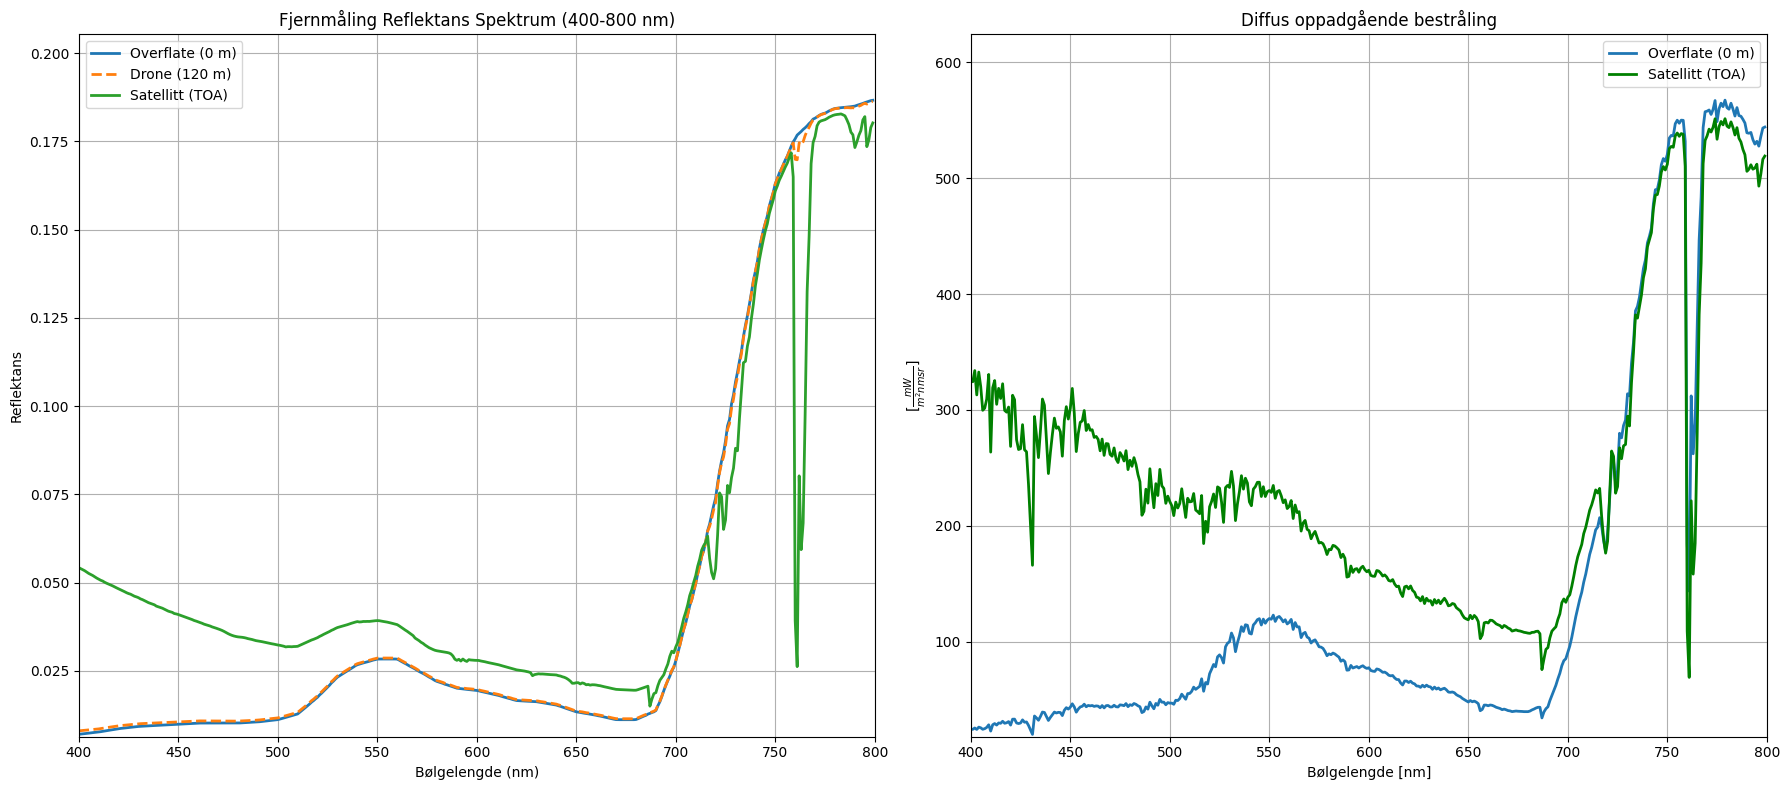

In [113]:
SC4_0m, SC4_120m, SC4_TOA = parse_output('Data/SC4.OUT')

# Calculate Chl-a for each dataset
chl_a_0m = calculate_chlorophyll_a(SC4_0m)
chl_a_120m = calculate_chlorophyll_a(SC4_120m)
chl_a_TOA = calculate_chlorophyll_a(SC4_TOA)

chl_df = pd.DataFrame({
    'Altitude': ['0 m', '120 m', 'TOA'],
    'Chl-a': [chl_a_0m.get('reflectance'), chl_a_120m.get('reflectance'), chl_a_TOA.get('reflectance')]
})

print(chl_df)

# Opprett en figur med to subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot reflektansspektra i den første subplot
ax[0].plot(SC4_0m['lambda'], SC4_0m['reflectance'], label='Overflate (0 m)', linewidth=2)
ax[0].plot(SC4_120m['lambda'], SC4_120m['reflectance'], label='Drone (120 m)', linewidth=2, linestyle='--')
ax[0].plot(SC4_TOA['lambda'], SC4_TOA['reflectance'], label='Satellitt (TOA)', linewidth=2)
ax[0].set_xlabel('Bølgelengde (nm)')
ax[0].set_ylabel('Reflektans')
ax[0].set_title('Fjernmåling Reflektans Spektrum (400-800 nm)')
ax[0].legend()
ax[0].set_xlim(400, 800)
ax[0].set_ylim(
    min(SC4_0m['reflectance'].min(), SC4_120m['reflectance'].min(), SC4_TOA['reflectance'].min()) * 0.9,
    max(SC4_0m['reflectance'].max(), SC4_120m['reflectance'].max(), SC4_TOA['reflectance'].max()) * 1.1
)
ax[0].grid(True)

# Plot gjennomsnittlig diffus oppadgående bestråling i den andre subplot
ax[1].plot(SC4_0m['lambda'], SC4_0m['eup'], label='Overflate (0 m)', linewidth=2)
ax[1].plot(SC4_TOA['lambda'], SC4_TOA['eup'], label='Satellitt (TOA)', color='green', linewidth=2)
ax[1].set_xlabel('Bølgelengde [nm]')
ax[1].set_ylabel(r'[$\frac{mW}{m^2 nm sr}$]')
ax[1].set_title('Diffus oppadgående bestråling')
ax[1].legend()
ax[1].set_xlim(400, 800)
ax[1].set_ylim(
    min(SC4_0m['eup'].min(), SC4_120m['eup'].min(), SC4_TOA['eup'].min()) * 0.9,
    max(SC4_0m['eup'].max(), SC4_120m['eup'].max(), SC4_TOA['eup'].max()) * 1.1
)
ax[1].grid(True)

# Juster layout
plt.tight_layout()
plt.show()

# Lekeplass

## Solspektrum

C:\Users\skaug\AppData\Local\Temp\ipykernel_16332\2086261236.py:9: DeprecationWarning: You are passing x=[ 250.  251.  252. ... 2998. 2999. 3000.] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  areal=sp.integrate.simpson(solar[:,1], solar[:,0])*10**(-3)
C:\Users\skaug\AppData\Local\Temp\ipykernel_16332\2086261236.py:10: DeprecationWarning: You are passing x=[ 250.  251.  252. ... 2998. 2999. 3000.] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  areal2=sp.integrate.simpson(solar2[:,1], solar2[:,0])*10**(-3)
C:\Users\skaug\AppData\Local\Temp\ipykernel_16332\2086261236.py:11: DeprecationWarning: You are passing x=[ 100  101  102 ... 2997 2998 2999] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these

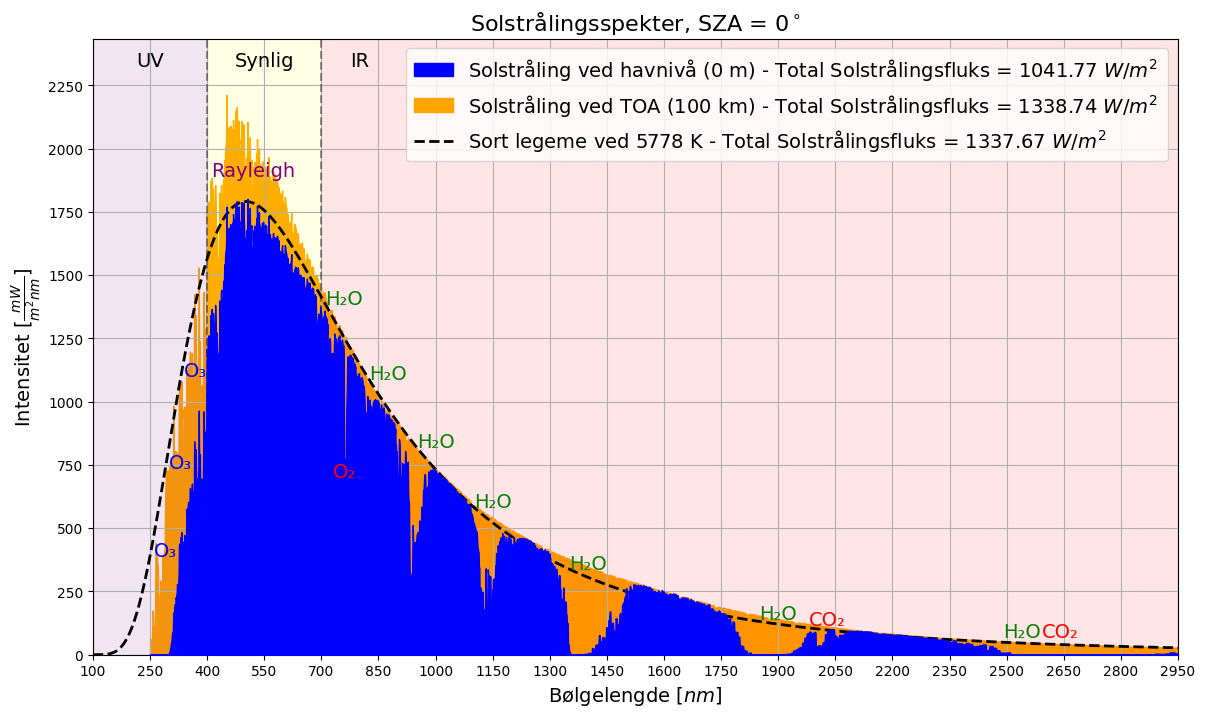

In [114]:
# Load solar spectrum data
solar = np.loadtxt('Data/solar.dat')
solar2 = np.loadtxt('Data/solar2.dat')

# Black Body Radiation (BB)
BBwave = np.arange(100, 3000, 1)
BB = BlackBodySun(BBwave * 10**(-9), 5778)

areal=sp.integrate.simpson(solar[:,1], solar[:,0])*10**(-3)
areal2=sp.integrate.simpson(solar2[:,1], solar2[:,0])*10**(-3)
areal3=sp.integrate.simpson(BB, BBwave)*10**(-3)

# Plot solar spectrum
plt.figure(figsize=(14, 8))

plt.fill_between(solar[:, 0], solar[:, 1], color='blue',zorder=3, label=f'Solstråling ved havnivå (0 m) - Total Solstrålingsfluks = {areal:.2f} $W/m^2$ ')
plt.fill_between(solar2[:, 0], solar2[:, 1], color='orange', label=f'Solstråling ved TOA (100 km) - Total Solstrålingsfluks = {areal2:.2f} $W/m^2$')
plt.plot(BBwave, BB, color='k', linestyle='--', linewidth=2, label=f'Sort legeme ved 5778 K - Total Solstrålingsfluks = {areal3:.2f} $W/m^2$')


# Annotate regions UV, Visible, and Infrared
plt.axvspan(100, 400, color='purple', alpha=0.1)  # UV region
plt.axvspan(400, 700, color='yellow', alpha=0.1)  # Visible region
plt.axvspan(700, 3000, color='red', alpha=0.1)    # Infrared region
plt.axvline(x=400, color='k', linestyle='--', alpha=0.4)
plt.axvline(x=700, color='k', linestyle='--', alpha=0.4)

plt.text(250, max(solar2[:, 1]) * 1.05, 'UV', fontsize=14, ha='center')
plt.text(550, max(solar2[:, 1]) * 1.05, 'Synlig', fontsize=14, ha='center')
plt.text(800, max(solar2[:, 1]) * 1.05, 'IR', fontsize=14, ha='center')

# Annotate known absorption regions for greenhouse gases
# Oxygen (O2)
plt.text(760, 700, 'O₂', color='red', fontsize=14, ha='center')

# Ozone (O3) 
plt.text(290, BB[300-150], 'O₃', color='blue', fontsize=14, ha='center')
plt.text(330, BB[340-150], 'O₃', color='blue', fontsize=14, ha='center')
plt.text(370, 1100, 'O₃', color='blue', fontsize=14, ha='center')

# Water vapor (H2O)
plt.text(760, BB[760-150], 'H₂O', color='green', fontsize=14, ha='center')
plt.text(875, BB[875-150], 'H₂O', color='green', fontsize=14, ha='center')
plt.text(1000, BB[1000-150], 'H₂O', color='green', fontsize=14, ha='center')
plt.text(1150, BB[1150-150], 'H₂O', color='green', fontsize=14, ha='center')
plt.text(1400, BB[1400-150], 'H₂O', color='green', fontsize=14, ha='center')
plt.text(1900, BB[1900-150]+10, 'H₂O', color='green', fontsize=14, ha='center')
plt.text(2540, BB[2400-150]+10, 'H₂O', color='green', fontsize=14, ha='center')

# Carbon dioxide (CO2) 
plt.text(2030, BB[2020-150]+10, 'CO₂', color='red', fontsize=14, ha='center')
plt.text(2640, BB[2400-150]+10, 'CO₂', color='red', fontsize=14, ha='center')

# Rayleigh scattering
plt.text(520, max(solar[:, 1]) * 1.05, 'Rayleigh', color='purple', fontsize=14, ha='center')

# Add labels and title
plt.xlabel(r'Bølgelengde [$nm$]',fontsize=14)
plt.ylabel(r'Intensitet [$\frac{mW}{m^2nm}$]',fontsize=14)
plt.title(r'Solstrålingsspekter, SZA = $0^\circ$',fontsize=16)
plt.ylim(0, max(solar2[:, 1])*1.1)
plt.xlim(100, 2950)
plt.xticks(np.arange(100, 3001, 150))
plt.yticks(np.arange(0, 2500, 250))
plt.grid(True)
plt.legend(fontsize=14)
plt.show()
